## Вводные
Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:
1. В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
2. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
3. Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

## Задание 1
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).  

reg_data.csv – данные о времени регистрации  
auth_data.csv – данные о времени захода пользователей в игру

Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from urllib.parse import urlencode
import seaborn as sns
import datetime
import scipy.stats as ss
pd.options.mode.chained_assignment = None

%matplotlib inline

In [2]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

reg_data_url = 'https://disk.yandex.ru/d/cd1YycONeuuVUQ'

auth_data_url = 'https://disk.yandex.ru/d/mVnipgZA1y-FlQ'

Для начала посмотрим на регистрации пользователей.

In [3]:
reg_data_final_url = base_url + urlencode(dict(public_key=reg_data_url)) 
response = requests.get(reg_data_final_url) 
download_url = response.json()['href']

download_response = requests.get(download_url) 
reg_data = pd.read_csv(download_url, sep=';') 

In [4]:
# Таблица, в которой хранятся данные о регистрации игроков.
# reg_ts - время регистрации. 
# uid - id игрока.
reg_data.head(3)

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3


In [5]:
reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [6]:
reg_data.uid.nunique()

1000000

За все время зарегестрировались 1 млн. человек.

Теперь посмотрим на таблицу с заходами в игру.

In [7]:
auth_data_final_url = base_url + urlencode(dict(public_key=auth_data_url)) 
response = requests.get(auth_data_final_url) 
download_url = response.json()['href']

download_response = requests.get(download_url) 
auth_data = pd.read_csv(download_url, sep=';') 

In [8]:
# Таблица, в которой хранятся данные о заходе игроков в игру. 
# auth_ts - время захода в игру.
# uid - id игрока.
auth_data.head(3)

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2


In [9]:
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [10]:
auth_data.shape

(9601013, 2)

In [11]:
auth_data.uid.nunique()

1000000

Переведем все в нормальные даты, с которыми можно будет удобно работать.  
В дальнейшем в функцию подадим "сырые" данные.

In [12]:
reg_data['reg_date'] = pd.to_datetime(reg_data['reg_ts'], unit='s').dt.date
reg_data['reg_date'] = pd.to_datetime(reg_data['reg_date'])

In [13]:
auth_data['auth_date'] = pd.to_datetime(auth_data['auth_ts'], unit='s').dt.date
auth_data['auth_date'] = pd.to_datetime(auth_data['auth_date'])

In [14]:
reg_data.head(3)

,reg_ts,uid,reg_date
0,911382223,1,1998-11-18
1,932683089,2,1999-07-22
2,947802447,3,2000-01-13


In [15]:
auth_data.head(3)

,auth_ts,uid,auth_date
0,911382223,1,1998-11-18
1,932683089,2,1999-07-22
2,932921206,2,1999-07-25


In [16]:
auth_data.shape

(9601013, 3)

In [17]:
auth_data[['uid', 'auth_date']].duplicated().sum()

0

Кажется, у нас есть некоторое кол-во ветеранов :)  

In [18]:
reg_data['reg_date'].dt.year.value_counts()

reg_date
2020    354963
2019    291102
2018    159729
2017     87645
2016     48187
2015     26344
2014     14455
2013      7932
2012      4361
2011      2385
2010      1308
2009       718
2008       394
2007       216
2006       119
2005        65
2004        35
2003        20
2002        10
2001         6
2000         4
1999         1
1998         1
Name: count, dtype: int64

Не совсем понятно, в каких играх могли зарегистрироваться наши ветераны. Кажется, первые мобильные игры с возможностью регистрации (с использованием интернета) появились в начале 2000-х. Но думаю, что сейчас это не особо важно.

Требуется написать функцию для расчета retention. Для проверки ее работоспособности я возьму только людей, которые зарегистрировались в 2020 году в марте.

In [19]:
reg_data.drop('reg_date', axis=1, inplace=True)
auth_data.drop('auth_date', axis=1, inplace=True)

In [20]:
def retention_func(reg_df, auth_df, day, from_date='', to_date='', safe_data=False):  
    
    '''Функция для расчета retention
    
    Аргументы
    ---------
    reg_data : pd.DataFrame с 2 столбцами: время регистрации в сек, id игрока
        информация о регистрациях игроков
    auth_data : pd.DataFrame с 2 столбцами: время захода в сек, id игрока
        информация о заходах игроков
    day : int
        день, до которого рассчитывается retention 
    from_date : str формата "yyyy-mm-dd"
        дата, от которой нужно брать когорты (по умолчанию мин. дата регистрации)
    to_date : str формата "yyyy-mm-dd"
        дата, до которой нужно брать когорты (по умолчанию макс. дата регистрации)
    safe_data : bool
        False меняет переданные датафреймы, True копирует датафреймы (по умолчанию False)
    
    Возвращает
    ----------
    DataFrame.style с рассчитанным retention
    
    '''
    # Проверка на необходимость копии датафреймов.
    if safe_data:
        reg_data = reg_df.copy()
        auth_data = auth_df.copy()
    else:
        reg_data = reg_df
        auth_data = auth_df
    
    # Проверяем даты для отбора когорт.
    flag_from = False
    flag_to = False
    
    if from_date != '':
        try:
            from_date = pd.to_datetime(from_date)
        except:
            return 'Введите дату, от которой нужно брать когорты.'
    else:
        flag_from = True
        
    if to_date != '':
        try:
            to_date = pd.to_datetime(to_date)
        except:
            return 'Введите дату, до которой нужно брать когорты.'
    else:
        flag_to = True
    
    # Приводим даты в датафреймах к формату yyyy-mm-dd и убираем столбцы с секундами.
    reg_data['reg_date'] = pd.to_datetime(reg_data['reg_ts'], unit='s').dt.date
    reg_data['reg_date'] = pd.to_datetime(reg_data['reg_date'])
    auth_data['auth_date'] = pd.to_datetime(auth_data['auth_ts'], unit='s').dt.date
    auth_data['auth_date'] = pd.to_datetime(auth_data['auth_date'])
    reg_data.drop('reg_ts', axis=1, inplace=True)
    auth_data.drop('auth_ts', axis=1, inplace=True)
    
    # Если какая-то граница для когорт не указана, то берется мин/макс значение.
    if flag_from:
        from_date = reg_data['reg_date'].min()
    if flag_to:
        to_date = reg_data['reg_date'].max()
        
    # Граница для заходов в игру.
    to_date_auth = to_date + datetime.timedelta(days=day)
    
    # Оставляем только когорты и заходы в необходимом промежутке.
    reg_data = reg_data.query('reg_date >= @from_date and reg_date <= @to_date')
    auth_data = auth_data.query('auth_date >= @from_date and auth_date <= @to_date_auth')
    
    # Избавляемся от дубликатов, если они есть.
    reg_data.drop_duplicates(inplace=True)
    auth_data.drop_duplicates(inplace=True)
    
    # Объединяем две таблицы в одну.
    all_data = reg_data.merge(auth_data, how='left', on='uid')
    
    # Добавляем столбец, в который запишем последний день расчета retention для когорты.
    all_data['last_day'] = all_data['reg_date'] + datetime.timedelta(days=day)
    
    # Убираем все данные о заходах, которые будут идти после этой границы.
    all_data = all_data.query('auth_date <= last_day')
    
    # Добавляем столбец с номером дня. 
    all_data['day_num'] = day - (all_data['last_day'] - all_data['auth_date']).dt.days
    
    # Группируем по дню регистрации и дню расчета retention, и считаем кол-во зашедших.
    retention_data = all_data.groupby(['reg_date', 'day_num'], as_index=False).agg({'uid':'count'})
    
    # Делаем пивот с кол-вом игроков в каждой когорте, зашедших в определенный день.
    retention_data = retention_data.pivot(index='reg_date', columns='day_num', values='uid').reset_index()
    
    # Убираем когорты, у которых в последний день нет заходов.
    retention_data = retention_data[retention_data[len(retention_data.columns)-2].notna()]
    
    # Меняем название столбца нулевого дня на 'Кол-во людей в когорте'.
    retention_data.rename(columns={0:'users_in_cohort'}, inplace=True)
    
    # Кол-во пользователей в день заменяем на процент.
    retention_data.update(retention_data.iloc[:, 2:].div(retention_data['users_in_cohort'], 0) * 100)
    
    # Выбираем стиль для таблицы.
    cm = sns.light_palette("seagreen", as_cmap=True)
    
    # Возвращаем retention таблицу.
    return retention_data.style.background_gradient(cmap=cm, axis=None, subset=retention_data.iloc[:, 2:].columns)

Пусть будет таблица с расчетом retention 7 дня.  
(Возможны баги с отображением стилей в гитхабе)

In [21]:
retention = retention_func(reg_data, auth_data, 7, '2020-03-01', '2020-03-31', True)

In [22]:
pd.set_option('display.max_rows', None)
retention

day_num,reg_date,users_in_cohort,1,2,3,4,5,6,7
0,2020-03-01 00:00:00,1172,1.962457,4.436860,4.863481,5.204778,4.607509,6.825939,5.204778
1,2020-03-02 00:00:00,1173,1.364024,3.665814,4.177323,4.944587,6.734868,6.052856,6.308610
2,2020-03-03 00:00:00,1176,2.380952,2.976190,4.846939,4.336735,5.357143,7.482993,4.761905
3,2020-03-04 00:00:00,1177,2.633815,4.502974,6.627018,5.182668,6.372133,7.221750,8.156330
4,2020-03-05 00:00:00,1180,2.881356,4.661017,4.576271,6.016949,5.169492,6.525424,6.271186
5,2020-03-06 00:00:00,1181,1.524132,3.556308,5.673158,4.657070,7.281964,6.519898,6.689246
6,2020-03-07 00:00:00,1183,2.028740,3.972950,4.733728,4.311074,5.832629,6.508876,4.564666
7,2020-03-08 00:00:00,1185,1.772152,4.135021,5.063291,5.907173,5.485232,6.666667,5.147679
8,2020-03-09 00:00:00,1187,1.853412,4.633530,3.875316,4.465038,5.391744,6.655434,6.149958
9,2020-03-10 00:00:00,1190,2.100840,2.689076,4.957983,4.873950,5.210084,6.470588,4.957983


In [23]:
pd.set_option('display.max_rows', 10)

## Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений.  
Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.  

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [24]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

ab_url = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'

In [25]:
ab_final_url = base_url + urlencode(dict(public_key=ab_url)) 
response = requests.get(ab_final_url) 
download_url = response.json()['href']

download_response = requests.get(download_url) 
ab_tab = pd.read_csv(download_url, sep=';') 

In [26]:
# Таблица с результатами a/b теста
# user_id - id пользователя
# revenue - доход с пользователя
# testgroup - группа(а или б), к которой относится пользователь
ab_tab.head(3)

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a


In [27]:
ab_tab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [28]:
ab_tab.nunique()

user_id      404770
revenue        1477
testgroup         2
dtype: int64

In [29]:
ab_tab.testgroup.value_counts()

testgroup
b    202667
a    202103
Name: count, dtype: int64

Пока никаких проблем с данными.

Посмотрим на распределения прибыли по группам.

[Text(0.5, 1.0, 'Тестовая группа')]

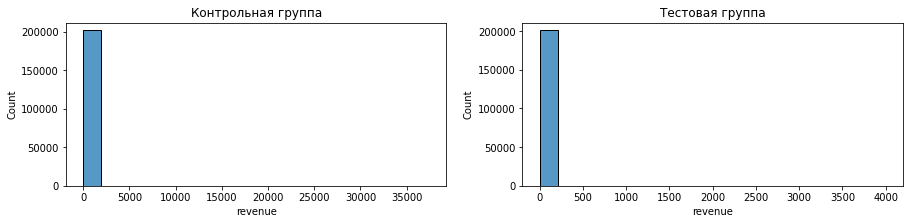

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
pd.set_option('mode.use_inf_as_na', True)
sns.histplot(ab_tab.query('testgroup == "a"'), x='revenue', ax=ax[0]).set(title='Контрольная группа')
sns.histplot(ab_tab.query('testgroup == "b"'), x='revenue', ax=ax[1]).set(title='Тестовая группа')

In [31]:
ab_tab.revenue.value_counts().head(1)

revenue
0    401037
Name: count, dtype: int64

Нулевых значений слишком много, нужно посмотреть на графики без них, но уже сейчас можно увидеть различия, если посмотреть на ось x, на которой отображены значения прибыли, которые встречаются в группе.

[Text(0.5, 1.0, 'Тестовая группа без нулевых значений')]

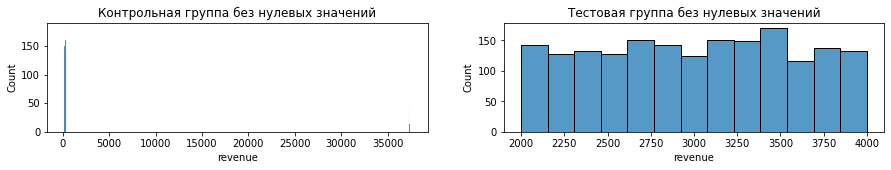

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(15, 2))
sns.histplot(ab_tab.query('testgroup == "a" and revenue > 0'), x='revenue', ax=ax[0]) \
    .set(title='Контрольная группа без нулевых значений')
sns.histplot(ab_tab.query('testgroup == "b" and revenue > 0'), x='revenue', ax=ax[1]) \
    .set(title='Тестовая группа без нулевых значений')

Теперь поделим контрольную группу на 2 части, чтобы посмотреть на значения.

[Text(0.5, 1.0, 'Часть контрольной группы без нулевых значений с большой прибылью')]

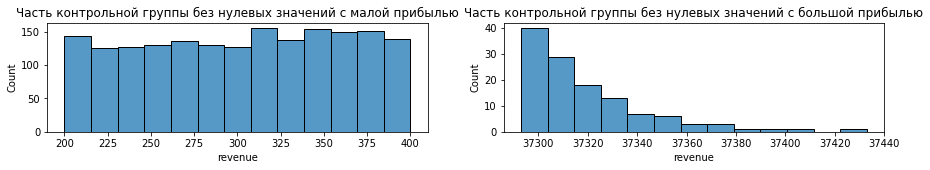

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(15, 2))
sns.histplot(ab_tab.query('testgroup == "a" and revenue > 0 and revenue < 30000'), x='revenue', ax=ax[0]) \
    .set(title='Часть контрольной группы без нулевых значений с малой прибылью')
sns.histplot(ab_tab.query('testgroup == "a" and revenue > 0 and revenue > 30000'), x='revenue', ax=ax[1]) \
    .set(title='Часть контрольной группы без нулевых значений с большой прибылью')

Если посмотреть на графики, можно заметить, что игроки, совершившие покупку, поделены на 3 группы:  
- Те, кто тратит мало денег (200-400) - тип 1
- Те, кто тратит среднее кол-во денег (2000-4000) - тип 2
- Те, кто тратит очень много денег (30000+) - тип 3

1 и 3 тип попали в контрольную группу, а 2 тип в тестовую.

#### Уже можно сказать, что данные нас не устраивают и проверять итоги теста не имеет смысла.
Могу предположить, что сломалась система сплитования, потому что между платящими в двух группах явный дисбаланс. Перед A/B тестом должны были прогнать A/A тесты, но об этом никаких данных нет.  
Даже если мы предположим, что наша система поделила пользователей правильно, то данный апдейт бизнесу вряд ли понравится. Никто не захочет терять 'китов', которые приносят колоссальное количество прибыли.


Ради интереса можно посмотреть на ARPU и ARPPU.

In [34]:
print('Выручка с группы А: ' + str(ab_tab.query('testgroup == "a"').revenue.sum()) + 
      ', где ARPU - ' + str(round(ab_tab.query('testgroup == "a"').revenue.mean(), 2)) +
      ' и ARPPU - ' + str(round(ab_tab.query('testgroup == "a" and revenue > 0').revenue.mean(), 2)))
print('Выручка с группы Б: ' + str(ab_tab.query('testgroup == "b"').revenue.sum()) + ', где ARPU - ' +
      str(round(ab_tab.query('testgroup == "b"').revenue.mean(), 2)) + ' и ARPPU - ' +
      str(round(ab_tab.query('testgroup == "b" and revenue > 0').revenue.mean(), 2)) + '\n')
print('Выручка с первого типа покупателей в группе А: ' 
      + str(ab_tab.query('testgroup == "a" and revenue < 30000').revenue.sum()) + 
      ', где ARPPU - ' + str(round(ab_tab.query('testgroup == "a" and revenue > 0 and revenue < 30000').revenue.mean(), 2)))
print('Выручка с третьего типа покупателей в группе А: ' 
      + str(ab_tab.query('testgroup == "a" and revenue > 30000').revenue.sum()) +
      ', где ARPPU - ' + str(round(ab_tab.query('testgroup == "a" and revenue > 0 and revenue > 30000').revenue.mean(), 2)))
print('\nARPU в группе А без игроков-покупателей третьего типа: ' + 
      str(round(ab_tab.query('testgroup == "a" and revenue < 30000').revenue.mean(), 2)))

Выручка с группы А: 5136189, где ARPU - 25.41 и ARPPU - 2664.0
Выручка с группы Б: 5421603, где ARPU - 26.75 и ARPPU - 3003.66

Выручка с первого типа покупателей в группе А: 545937, где ARPPU - 302.46
Выручка с третьего типа покупателей в группе А: 4590252, где ARPPU - 37319.12

ARPU в группе А без игроков-покупателей третьего типа: 2.7


Если посмотреть на средние траты пользователей в группах, то становится понятно, что "выбросы" очень сильно влияют на ARPU и ARPPU контрольной группы. Если бы "выбросов" в контрольной группе не было, то при примерно равной конверсии у нас было бы одинаковое кол-во заплативших в двух группах и их ARPU и ARPPU отличались бы при этом на порядок (не в пользу контрольной группы).  

Для нормальной проверки итогов A/B теста, группы должны быть сбалансированными, но в данном случае это требование не соблюдается. 1 и 3 типы игроков-покупателей попали в контрольную группу, а 2 тип в тестовую.  
Я думаю, что смысла в сравнении двух этих групп нет, из-за возможной поломки в системе сплитования.

## Задание 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

### Случай первый

Наша цель привлекать новых пользователей(возвращать старых, удерживать текущих) и увеличивать прибыль. Нам нужно понимать, что нравится игрокам и как наши обновления влияют на продукт. Мы можем посмотреть на
- DAU/MAU. Если с игрой все в порядке, то новые интересные ивенты должны бустить эти показатели.
- Stickiness Rate и Retention Rate. Можно посмотреть на то, как разные ивенты/тематики удерживают пользователей.
- Процент игроков, принявших участие в ивенте. Узнаем был ли интересен игрокам сам ивент/тематика. Можем сравнить с другими ивентами и сделать предположения о том, что нравится игрокам.
- Процент игроков, закончивших ивент полностью. Можно оценить сложность ивента, возможно, ценность финальной награды.
- Average Playtime.  Нужно стараться увеличить время игры, но чтобы это не отталкивало игроков. Игроки должны оставаться из-за интересного контента и механик, а не из-за невероятной сложности или чего-то подобного.
- Среднее кол-во попыток на уровень. Можем оценить сложность уровней. Если есть уровень, в который упираются игроки, мы сможем это увидеть и пофиксить.

Можно также посмотреть на метрики прыбыли. Новые ивенты с интересными тематиками и уникальными наградами могут привлекать новых игроков и удерживать старых. Эти люди, возможно, будут совершать внутриигровые покупки.

### Случай второй

Про метрики из первого случая не забываем, понятно, что разные метрики могут просесть. Например, процент игроков завершивших ивент полностью может упасть, или Average Playtime может увеличится или уменьшиться из-за сложности и начнет отталкивать игроков. Вместе с метриками из первого случая мы можем смотреть на дополнительные:
- Процент людей, которые прошли ивент без откатов. Если процент слишком высок, возможно, что-то работает неправильно.
- Среднее кол-во откатов после которого люди бросают ивент. 
- Среднее кол-во откатов на игрока. Этот показатель должен быть ниже предыдущей метрики.